## 뉴스 요약봇 만들기

## 목차
1. 데이터 수집하기
2. 데이터 전처리하기
3. 어텐션 메커니즘 사용하기
4. 실제 결과와 요약문 비교하기
5. Summa을 이용해서 추출적 요약해보기

|  평가문항 |  상세기준 |
| :------------ | :------------ |
|  1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  |  모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다. |
| 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.  |

In [219]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기

In [220]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [221]:
data.sample(10)

,headlines,text
77805,"US, Georgia hold military drills amid tensions...",Georgia began the 'Noble Partner' military exe...
4522,Lok Sabha passes bill to make instant Triple T...,The Lok Sabha has passed the Muslim Women (Pro...
28514,Maradona collapses as Argentina win do-or-die ...,Argentine legend Diego Maradona had to be assi...
633,Few states opted out of Modicare due to politi...,Defence Minister Nirmala Sitharaman has said i...
40104,Horror film based on rape-accused producer Wei...,Hollywood director Brian De Palma has said he ...
38282,"Who was Shujaat Bukhari, journalist shot dead ...","Shujaat Bukhari, who was shot dead by terroris..."
995,Aamir's 'Rubaru Roshni' screened for Sri Sri R...,Aamir Khan screened his upcoming short film 'R...
55549,Platinum Love Bands for couples to commemorate...,The newly launched collection of Ã¢ÂÂPlatinu...
72769,70 lakh youths to get jobs in 5 years: Uttar P...,Uttar Pradesh Chief Minister Yogi Adityanath o...
15707,Saw goons harass Tanushree on sets of Nana Pat...,Talk show host-journalist Janice Sequeira has ...


## Step 2. 데이터 전처리하기

In [222]:
# 데이터 전체 길이
len(data)

98401

In [223]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [224]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [225]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


In [226]:
# null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [227]:
#불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [228]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [229]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [230]:
# text 데이터 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [231]:
# headlines 데이터 전처리
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [232]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [233]:
# null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [234]:
import seaborn as sns
# 문장 길이 그래프
def data_len(data_text, bins=50):
    # 텍스트데이터 문장길이의 리스트를 생성한 후
    num_tokens = [len(tokens.split()) for tokens in data_text]
    num_tokens = np.array(num_tokens)
    
    # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))
    
    # 그래프
    sns.histplot(num_tokens, kde = True, bins=bins, color="g")
    
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('maxlen : ', maxlen)
    print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
    
    return maxlen

문장길이 평균 :  35.10029309397326
문장길이 최대 :  60
문장길이 표준편차 :  3.7996134352887116
maxlen :  42
전체 문장의 0.9750157741548106%가 maxlen 설정값 이내에 포함됩니다. 


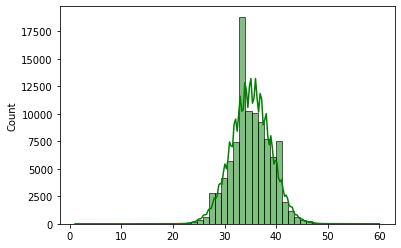

In [235]:
text_max_len = data_len(data['text'], 50)

문장길이 평균 :  9.299444342675704
문장길이 최대 :  16
문장길이 표준편차 :  1.3899968497820723
maxlen :  12
전체 문장의 0.9880319960920804%가 maxlen 설정값 이내에 포함됩니다. 


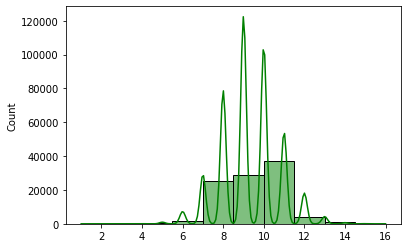

In [236]:
headlines_max_len = data_len(data['headlines'], 10) 

In [237]:
# 정해진 길이보다 긴 내용 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 94658


In [238]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [239]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [240]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[89193 87370 86885 ... 83360 49749 71232]


In [241]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [242]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18931


In [243]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75727
훈련 레이블의 개수 : 75727
테스트 데이터의 개수 : 18931
테스트 레이블의 개수 : 18931


In [244]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [245]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67977
등장 빈도가 6번 이하인 희귀 단어의 수: 46268
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21709
단어 집합에서 희귀 단어의 비율: 68.06419818468011
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5476292861966527


In [246]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [247]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[903, 32, 365, 2051, 2950, 7122, 5329, 1955, 7122, 5329, 60, 32, 992, 152, 1377, 2950, 2596, 7122, 5329, 5825, 109, 31, 10, 293, 10, 150, 1199, 1955], [173, 256, 728, 56, 771, 442, 1200, 970, 147, 442, 472, 1644, 1428, 5170, 275, 1866, 104, 173, 256, 2977, 442, 970, 6073, 895, 1059, 55, 3187, 2125, 1565, 5207, 191, 2951], [1849, 560, 3301, 14, 2687, 6841, 95, 2118, 201, 1071, 2990, 4889, 7123, 1945, 6763, 749, 7124, 1125, 1, 201, 2, 4297, 95, 14, 1363, 2298, 4297]]


In [248]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [249]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29610
등장 빈도가 5번 이하인 희귀 단어의 수: 19400
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10210
단어 집합에서 희귀 단어의 비율: 65.51840594393786
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.788755245547642


In [250]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 631, 5, 146, 4032, 3074, 3, 3679, 6029], [1, 24, 1923, 472, 842, 3, 18, 4549, 358, 128], [1, 6, 18, 2707, 7, 77, 270, 6320, 1664], [1, 204, 19, 1439, 1604, 769, 2001, 16, 72, 467, 7, 5501, 453], [1, 959, 206, 2827, 7, 22, 39, 93, 69, 3, 3493, 5502]]
target
decoder  [[631, 5, 146, 4032, 3074, 3, 3679, 6029, 2], [24, 1923, 472, 842, 3, 18, 4549, 358, 128, 2], [6, 18, 2707, 7, 77, 270, 6320, 1664, 2], [204, 19, 1439, 1604, 769, 2001, 16, 72, 467, 7, 5501, 453, 2], [959, 206, 2827, 7, 22, 39, 93, 69, 3, 3493, 5502, 2]]


In [251]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 75727
훈련 레이블의 개수 : 75727
테스트 데이터의 개수 : 18930
테스트 레이블의 개수 : 18930


In [252]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 

In [253]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [254]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [255]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 42, 256)      2048000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 42, 512), (N 1574912     embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### 어텐션 메커니즘

In [256]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 42, 256)      2048000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 42, 512), (N 1574912     embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [257]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# restore_best_weights = True로 최상의 결과 저장하기
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
296/296 [==============================] - 207s 672ms/step - loss: 5.3414 - val_loss: 4.8856
Epoch 2/50
296/296 [==============================] - 197s 665ms/step - loss: 4.6427 - val_loss: 4.3731
Epoch 3/50
296/296 [==============================] - 195s 658ms/step - loss: 4.2009 - val_loss: 4.0573
Epoch 4/50
296/296 [==============================] - 194s 656ms/step - loss: 3.8847 - val_loss: 3.8608
Epoch 5/50
296/296 [==============================] - 194s 654ms/step - loss: 3.6402 - val_loss: 3.7247
Epoch 6/50
296/296 [==============================] - 194s 657ms/step - loss: 3.4383 - val_loss: 3.6375
Epoch 7/50
296/296 [==============================] - 196s 663ms/step - loss: 3.2683 - val_loss: 3.5600
Epoch 8/50
296/296 [==============================] - 195s 658ms/step - loss: 3.1185 - val_loss: 3.5178
Epoch 9/50
296/296 [==============================] - 193s 653ms/step - loss: 2.9862 - val_loss: 3.4785
Epoch 10/50
296/296 [==============================] - 195s 658m

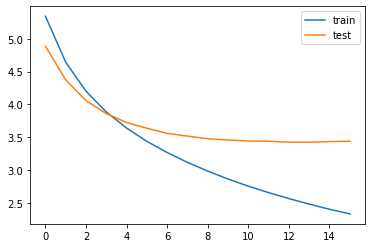

In [258]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [259]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [260]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [261]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [262]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기

In [263]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [264]:
j = 1
for i in range(10, 15):
    print(j,"원문 :", seq2text(encoder_input_test[i]))
    print("\n")
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("-----------------------------------------------------------------------------")
    print("\n")
    j += 1

1 원문 : salman khan shared video nephew son sister khan sharma seen slapping khan seen holding child salman song film sultan mock fight first birthday entire khan family travelled maldives grand celebration 


실제 요약 : video shows salman being slapped by nephew 
예측 요약 :  salman khan shares video of his brother debut with brother
-----------------------------------------------------------------------------


2 원문 : south korean electronics giant samsung trolled google releasing video quality screens galaxy smartphones comes users reported pixel screens turning grey within week device usage suggests burn samsung captioned video top tech share thoughts amazing galaxy screen 


실제 요약 : samsung trolls google over pixel xl screen burn in reports 
예측 요약 :  samsung galaxy to let users galaxy
-----------------------------------------------------------------------------


3 원문 : priyanka chopra said wrote new single young free time life lyrics born need freedom whatever freedom may mean one us add

## padding에 따른 결과 차이
### padding post
1. 원문 : telugu fastest growing language us study us based centre immigration studies claimed rise number us residents speaking telugu attributed growth industry country software engineers india telugu speaking states andhra pradesh telangana non profit organisation foundation said 

실제 요약 : fastest language in us study   
예측 요약 :  world most important in us

---------------------------------------------------------------------------

2. 원문 : congress observe black day november hold protests states said party reportedly target government demonetisation allegedly poor handling economy congress president rahul gandhi may lead protest delhi former pm manmohan singh may also participate agitation 


실제 요약 : cong to black day on nd demonetisation anniversary   
예측 요약 :  cong to take as new party in chhattisgarh

---------------------------------------------------------------------------

3. 원문 : year old rickshaw died allegedly beaten set ablaze unknown persons district rajasthan police said victim sleeping night incident took place city area said 

실제 요약 : sexually murdered in rajasthan   
예측 요약 :  year old dies after being by in rajasthan

---------------------------------------------------------------------------

4. 원문 : pakistan lost first test new zealand four runs failing make runs seven wickets hand one point fourth day test monday four run win fourth margin victory runs history test cricket debutant patel man match 


실제 요약 : pak lose by runs fail to make runs with in hand   
예측 요약 :  pakistan beat desh to take wickets in test series

---------------------------------------------------------------------------

5. 원문 : microsoft developing tool automatically identify bias different artificial intelligence according mit technology review although tool may eliminate problem completely help researchers businesses use ai without certain people microsoft executive said goal well added 


실제 요약 : microsoft to spot in ai   
예측 요약 :  microsoft ai to develop ai to

---------------------------------------------------------------------------
### Padding pre 

1 원문 : telugu fastest growing language us study us based centre immigration studies claimed rise number us residents speaking telugu attributed growth industry country software engineers india telugu speaking states andhra pradesh telangana non profit organisation foundation said 


실제 요약 : fastest language in us study   
예측 요약 :  us to create fastest in us

-----------------------------------------------------------------------------


2 원문 : congress observe black day november hold protests states said party reportedly target government demonetisation allegedly poor handling economy congress president rahul gandhi may lead protest delhi former pm manmohan singh may also participate agitation 


실제 요약 : cong to black day on nd demonetisation anniversary   
예측 요약 :  cong mps protest against mps for th time

-----------------------------------------------------------------------------


3 원문 : year old rickshaw died allegedly beaten set ablaze unknown persons district rajasthan police said victim sleeping night incident took place city area said 


실제 요약 : sexually murdered in rajasthan   
예측 요약 :  dies after being beaten by in

-----------------------------------------------------------------------------


4 원문 : pakistan lost first test new zealand four runs failing make runs seven wickets hand one point fourth day test monday four run win fourth margin victory runs history test cricket debutant patel man match 


실제 요약 : pak lose by runs fail to make runs with in hand   
예측 요약 :  pak record their highest ever odi total in

-----------------------------------------------------------------------------


5 원문 : microsoft developing tool automatically identify bias different artificial intelligence according mit technology review although tool may eliminate problem completely help researchers businesses use ai without certain people microsoft executive said goal well added 


실제 요약 : microsoft to spot in ai   
예측 요약 :  microsoft to launch ai to prevent

-----------------------------------------------------------------------------

## Step 5. Summa을 이용해서 추출적 요약해보기

In [148]:
import requests
from summa.summarizer import summarize

In [152]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
s_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [153]:
text = s_data['text']

In [191]:
k = 1
for i in range(10, 15):
    print(k,"원문 :", s_data['text'][i])
    print("\n")
    print("실제 요약 :", s_data['headlines'][i])
    print("-----------------------------------------------------------------------------")
    for j in range(5, 11):
        print("ratio:", j*0.1)
        print("예측 요약 :", summarize(text[i], ratio=j*0.1))
        print("-----------------------------------------------------------------------------")
        print("\n")
    print("words:", 10)
    print("예측 요약 :", summarize(text[i], words=20))
    print("-----------------------------------------------------------------------------")
    print("\n")
    k += 1

1 원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.


실제 요약 : UP cousins fed human excreta for friendship with boys
-----------------------------------------------------------------------------
ratio: 0.5
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.
-----------------------------------------------------------------------------


ratio: 0.6000000000000001
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two 

## ratio 0.1 ~ 0.5
1 원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.


실제 요약 : UP cousins fed human excreta for friendship with boys

-----------------------------------------------------------------------------
ratio: 0.1
예측 요약 :   
words: 5
예측 요약:

-----------------------------------------------------------------------------


ratio: 0.2
예측 요약 :   
words: 10
예측 요약:

-----------------------------------------------------------------------------


ratio: 0.30000000000000004
예측 요약 :   
words: 15
예측 요약:

-----------------------------------------------------------------------------


ratio: 0.4
예측 요약 :    
words: 20
예측 요약: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------

## ratio 0.5 ~ 0.8

ratio: 0.5
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.
words: 25
예측 요약: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------


1 원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.


실제 요약 : UP cousins fed human excreta for friendship with boys

-----------------------------------------------------------------------------
ratio: 0.5
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------


ratio: 0.6
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------


ratio: 0.7
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------


ratio: 0.8
예측 요약 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.

-----------------------------------------------------------------------------


- 데이터를 전처리한 문장의 경우 요약 결과를 가져오지 못함
- 0.3보다 작은 경우는 요약 결과를 가져오지 못함
- 0.4의 경우 요약 결과를 가져오는 경우와 못 가져오는 경우가 있다.
- words도 숫자가 낮으면 요약 결과를 못 가져오는 예도 있다.
- 이 데이터의 경우 ratio 값이 0.5부터 요약 문장이 모두 같은 것을 볼 수 있다.
- 0.7 이상이 되면 문장을 그대로 가져오는 경우가 발생한다.
- 문장 길이가 짧아 ratio, words 값이 크게 영향을 주지 못한다.

### 두 요약문 결과 비교

- 추출적 요약은 원본 데이터에서 그대로 가져오다 보니 문장이나 문법이 추상적 요약보다 자연스럽습니다.
- 데이터의 문장길이가 길지 않아서 그런지 추출적 요약은 문장의 앞이나 뒤를 기준으로 가져오는 모습이 보입니다.
- 추상적 요약의 경우 실제 요약에서 사용된 단어를 가져오는 것으로 보아 키워드를 잘 가져오고 있는 것으로 보입니다. 
- 이번 데이터는 문장의 길이가 짧아 추출적 요약의 경우 문장을 그대로 가져오다 보니 키워드를 잘 가져올 수 있는 구조라고 생각이 됩니다.

## 회고

- 추출적 요약의 경우 데이터를 전처리한 문장을 입력값으로 넣으면 요약 결과를 가져오지 못한다.
- 추출적 요약의 경우 특수문자 '.' 등을 이용하여 문장의 끝을 판단하는 것 같습니다. 그래서 특수문자 등을 지우면 전체를 한 문장으로 판단하여 문장을 요약하지 못 하는 것 같습니다.
- 추상적 요약에서 hidden size나 embedding_dim의 크기를 늘렸을 때 val_loss는 높아졌지만, 요약문의 성능은 더 증가한 것으로 판단됩니다.
- 많은 양의 데이터가 없다면 추출적 요약이 더 성능이 좋을 것 같지만 많은 데이터와 모델을 잘 만든다면 추상적 요약 또한 좋은 결과를 만들 수 있을 것 같습니다.
- 데이터의 문장이 짧은 경우 추출적 요약에서 ratio, words 값의 영향이 거의 없습니다.
- 추상적 요약의 경우 중요한 단어라고 생각되는 경우 2번 가져오기도 하는 것 같습니다.